In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
from tensorflow.keras import models, layers, optimizers
from tensorflow.python.keras.saving import hdf5_format
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import h5py, itertools, collections
import itertools
import cv2
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
print("Tensorflow version: " + tf.__version__)


GPU is NOT used.
Tensorflow version: 2.10.0


In [3]:
image_size = (64, 64)
# We define the batch size
batch_size = 64

# Create an image generator with a fraction of images reserved for validation:
image_generator = ImageDataGenerator(zoom_range=[0.5,1.0],
                                     brightness_range=[0.2,1.0],
                                     rotation_range=45,
                                     horizontal_flip=True
                                     )


In [4]:
train_ds =  DirectoryIterator(
    r'E:\Roaa\collage material\6th semester\slash\train',
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'training',
)
val_gen = ImageDataGenerator(validation_split=0.2)
val_ds = DirectoryIterator(
    r'E:\Roaa\collage material\6th semester\slash\train',
    val_gen,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'validation',
    shuffle=False
)

# We save the list of classes (labels).
class_names = list(train_ds.class_indices.keys())

# We also save the number of labels.
num_classes = train_ds.num_classes



Found 3341 images belonging to 7 classes.
Found 665 images belonging to 7 classes.


In [5]:
print(class_names)
print(num_classes)


['Accessories', 'Artifacts', 'Beauty', 'Fashion', 'Games', 'Home', 'Nutrition']
7


C:\Users\green\.conda\envs\myenv\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


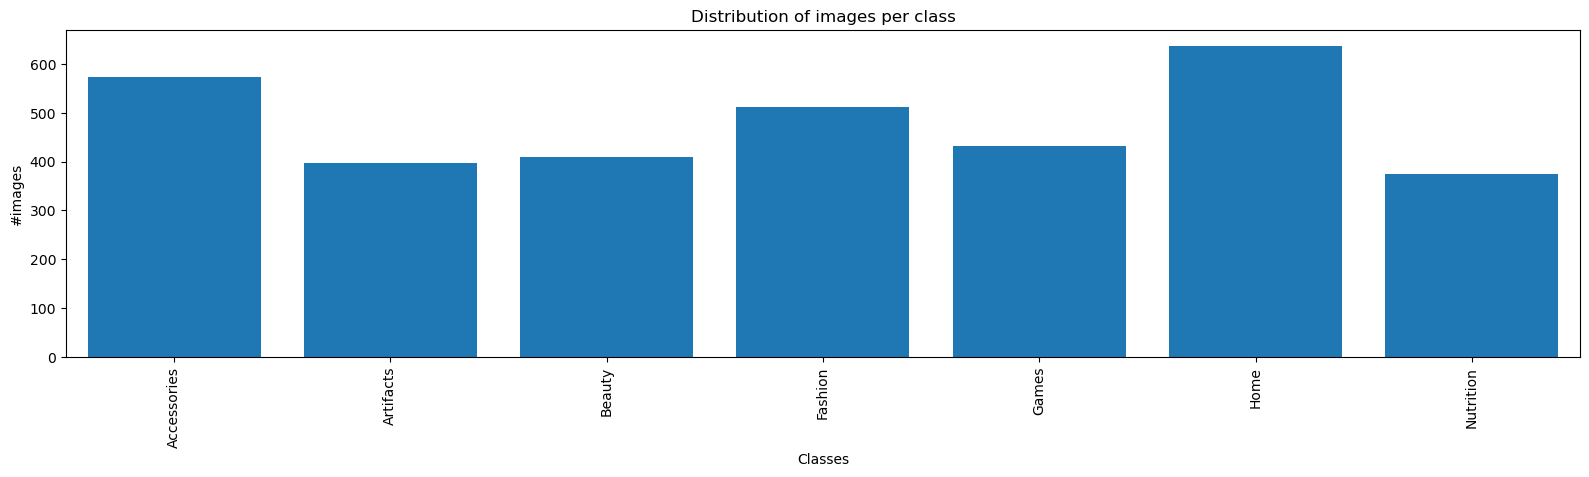

In [6]:
counter=collections.Counter(train_ds.labels)
v = [ [class_names[item[0]],item[1]]  for item in counter.items()]
df = pd.DataFrame(data=v, columns=['index','value'])
g = sns.catplot(x='index', y= 'value',  data=df, kind='bar', 
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class")
plt.xticks(rotation='vertical')
plt.show()

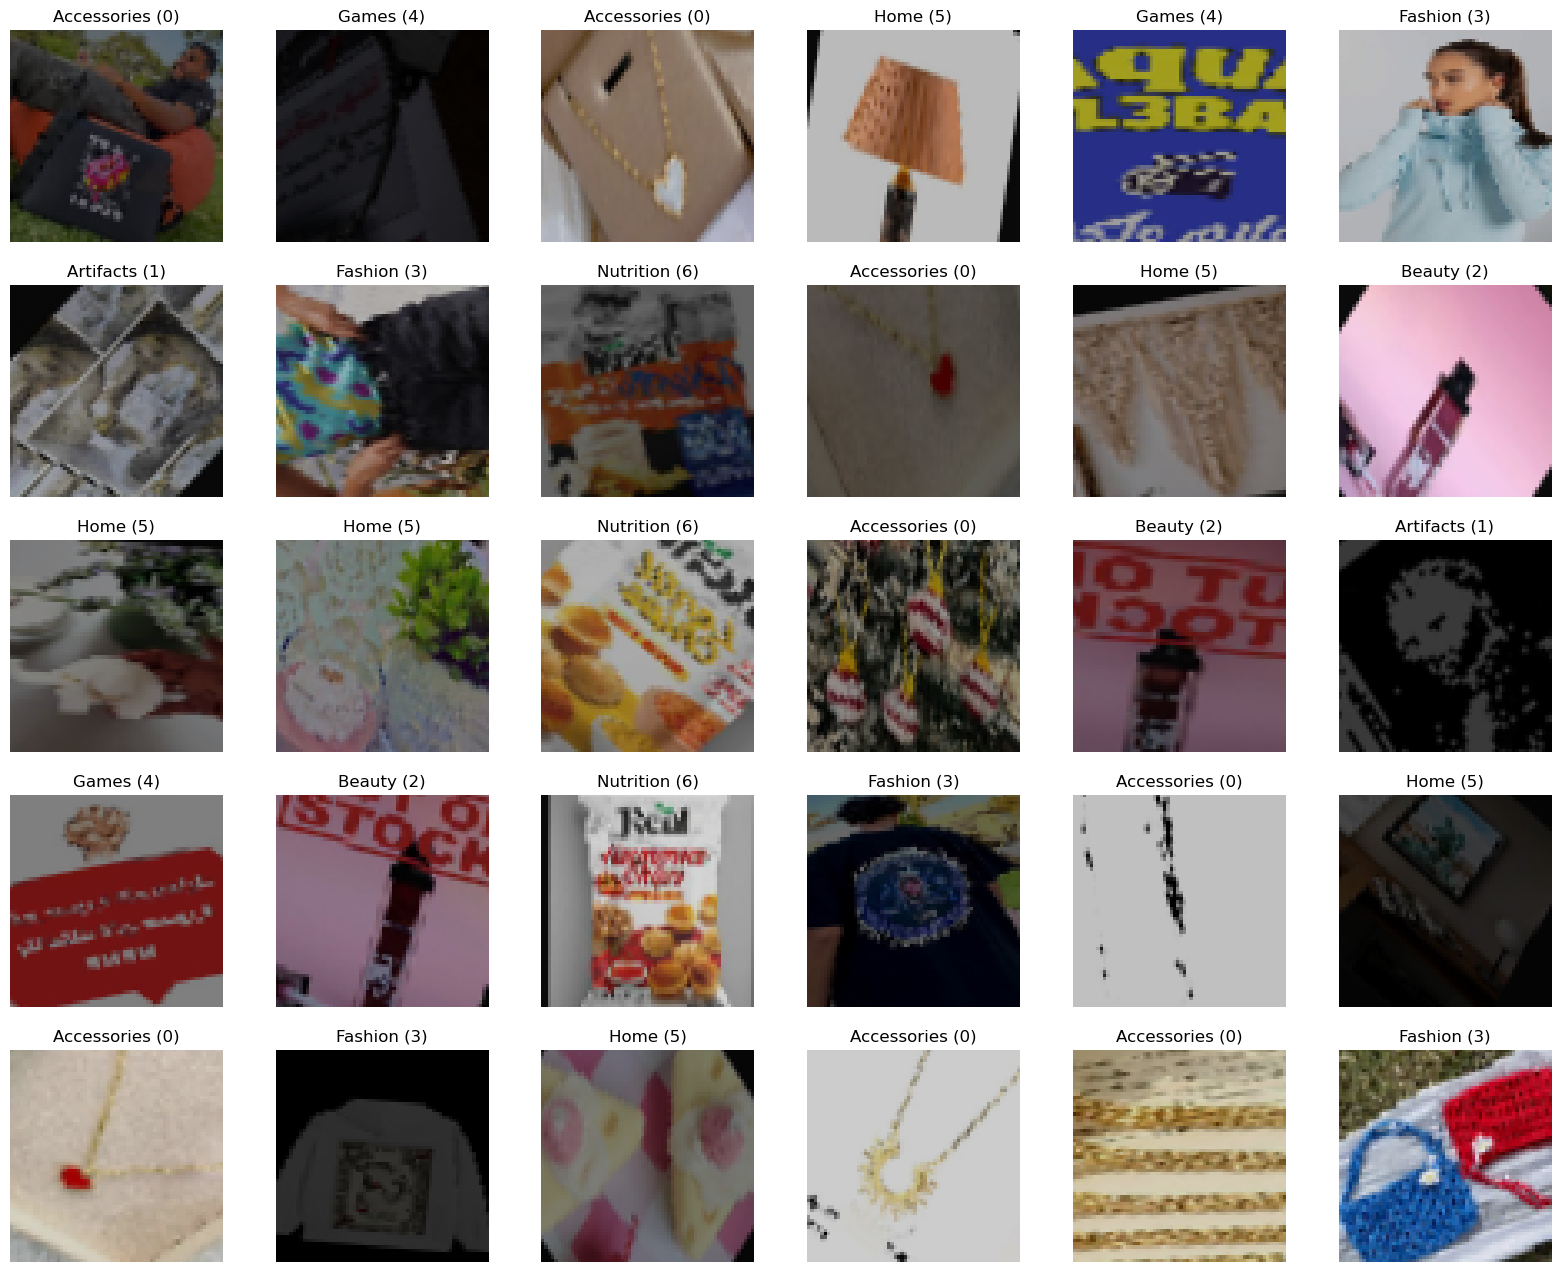

In [7]:
plt.figure(figsize=(20, 16))
images = []
labels = []
for itr in train_ds.next():
    for i in range(30):
        if len(images) < 30:
            images.append(itr[i].astype("uint8"))
        else:
            labels.append(list(itr[i]).index(1))

for i in range(len(images)):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]].replace('_',' ') +' ('+str(int(labels[i]))+')')
    plt.axis("off")

In [34]:
pip install Augmentor



     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     --------------------------- ---------- 41.0/57.6 kB 991.0 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 375.8 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 303.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ------------------------------- -------- 61.4/78.3 kB 1.1 MB/s eta 0:00:01
   ------------------------------------ --- 71.7/78.3 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 78.3/78.3 kB 618.7 kB/s eta 0:00:00


In [55]:
import Augmentor

In [83]:
p = Augmentor.Pipeline(r'E:\Roaa\collage material\6th semester\slash\train')
p.flip_left_right(0.5)
p.black_and_white(0.1)
p.rotate(0.3, 10, 10)
p.skew(0.4, 0.5)
p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.sample(920)

Initialised with 3341 image(s) found.
Output directory set to E:\Roaa\collage material\6th semester\slash\train\output.

Processing <PIL.Image.Image image mode=RGB size=419x540 at 0x23777275550>:   4%| | 36/920 [00:01<00:43, 20.47 Samples/s


AttributeError: 'FileNotFoundError' object has no attribute 'message'

In [8]:
model = models.Sequential()
model.add(keras.Input(shape=image_size + (3,))) 
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Conv2D(32, (3,3), padding='SAME', activation='relu'))
model.add(layers.Conv2D(32, (3,3), padding='SAME', activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.GaussianNoise(0.1))
model.add(layers.Conv2D(64, (3,3), padding='SAME', activation='relu'))
model.add(layers.Conv2D(64, (3,3), padding='SAME', activation='relu'))
model.add(layers.MaxPool2D())
#model.add(layers.Dropout(0.2))
model.add(layers.SpatialDropout2D(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='SAME', activation='relu'))
#Dense part
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(7, activation='softmax', activity_regularizer=tf.keras.regularizers.l2(0.001)))
# Print a summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                          

In [9]:
model.compile(optimizer=optimizers.SGD(lr=0.01, momentum=0.7),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])


C:\Users\green\.conda\envs\myenv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.01, patience=4, min_lr=0.001)
mcp_save = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')


In [11]:
history = model.fit(
    train_ds, epochs=30, batch_size=64,
    steps_per_epoch=int(train_ds.samples / batch_size),
    validation_data=val_ds, callbacks=[early_stopping, lr_on_plateu, mcp_save]
)


Epoch 1/30
52/52 [==============================] - 90s 2s/step - loss: 2.0027 - accuracy: 0.1831 - val_loss: 1.9383 - val_accuracy: 0.1699 - lr: 0.0100
Epoch 2/30
52/52 [==============================] - 81s 2s/step - loss: 1.9223 - accuracy: 0.2014 - val_loss: 1.9273 - val_accuracy: 0.1910 - lr: 0.0100
Epoch 3/30
52/52 [==============================] - 80s 2s/step - loss: 1.8614 - accuracy: 0.2594 - val_loss: 1.9050 - val_accuracy: 0.2015 - lr: 0.0100
Epoch 4/30
52/52 [==============================] - 85s 2s/step - loss: 1.7787 - accuracy: 0.3158 - val_loss: 1.9861 - val_accuracy: 0.2241 - lr: 0.0100
Epoch 5/30
52/52 [==============================] - 85s 2s/step - loss: 1.7034 - accuracy: 0.3555 - val_loss: 2.0929 - val_accuracy: 0.2286 - lr: 0.0100
Epoch 6/30
52/52 [==============================] - 84s 2s/step - loss: 1.6325 - accuracy: 0.3924 - val_loss: 2.6454 - val_accuracy: 0.1789 - lr: 0.0100
Epoch 7/30
52/52 [==============================] - 85s 2s/step - loss: 1.5708 - a

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

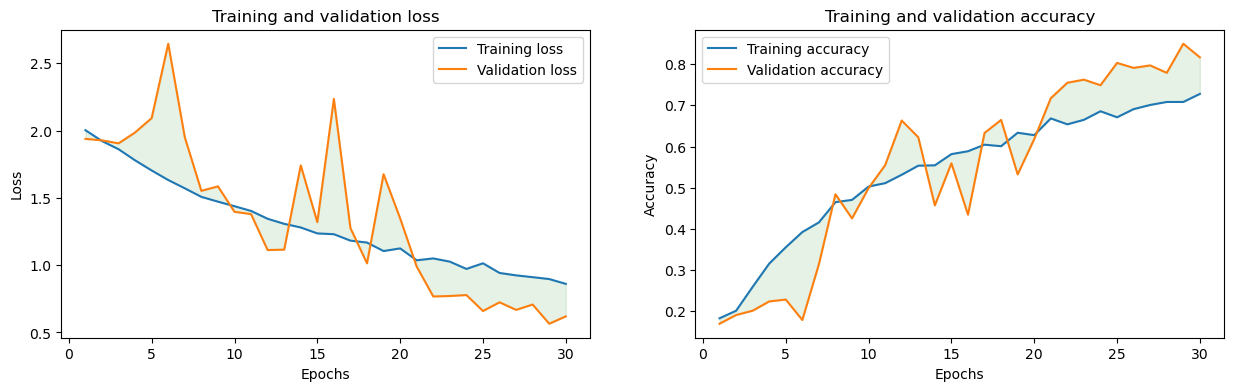

In [13]:
plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:
class_names

['Accessories', 'Artifacts', 'Beauty', 'Fashion', 'Games', 'Home', 'Nutrition']

In [15]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
print(classification_report(y_true, y_pred, target_names=class_names))

11/11 [==============================] - 6s 501ms/step
              precision    recall  f1-score   support

 Accessories       0.84      0.51      0.63       114
   Artifacts       0.87      1.00      0.93        79
      Beauty       0.80      0.90      0.85        82
     Fashion       0.90      0.73      0.80       102
       Games       0.89      1.00      0.94        86
        Home       0.67      0.76      0.71       127
   Nutrition       0.85      1.00      0.92        75

    accuracy                           0.82       665
   macro avg       0.83      0.84      0.83       665
weighted avg       0.82      0.82      0.81       665



In [16]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    vmax = cm.max()
    if normalize:
        title = 'Confusion matrix (normalized)'
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = [[int(j*100) for j in i ] for i in cm]
        cm =np.array(cm)
        vmax = 100
        
    plt.figure(figsize=(8,8))

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=vmax)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.show()




In [17]:
val_ds.reset()
val_ds.shuffle = True

plt.figure(figsize=(16, 16))
images = []
labels_pred = []
labels_true = []
for itr in val_ds.next():
    for i in range(25):
        if len(images) < 25:
            images.append(itr[i].astype("uint8"))
            y_proba = model.predict(np.array([itr[i]]))
            y_pred = np.argmax(y_proba,axis=1)[0]
            labels_pred.append(y_pred)
        else:
            labels_true.append(list(itr[i]).index(1))
    

1/1 [==============================] - 0s 42ms/step


<Figure size 1600x1600 with 0 Axes>

11/11 [==============================] - 4s 387ms/step


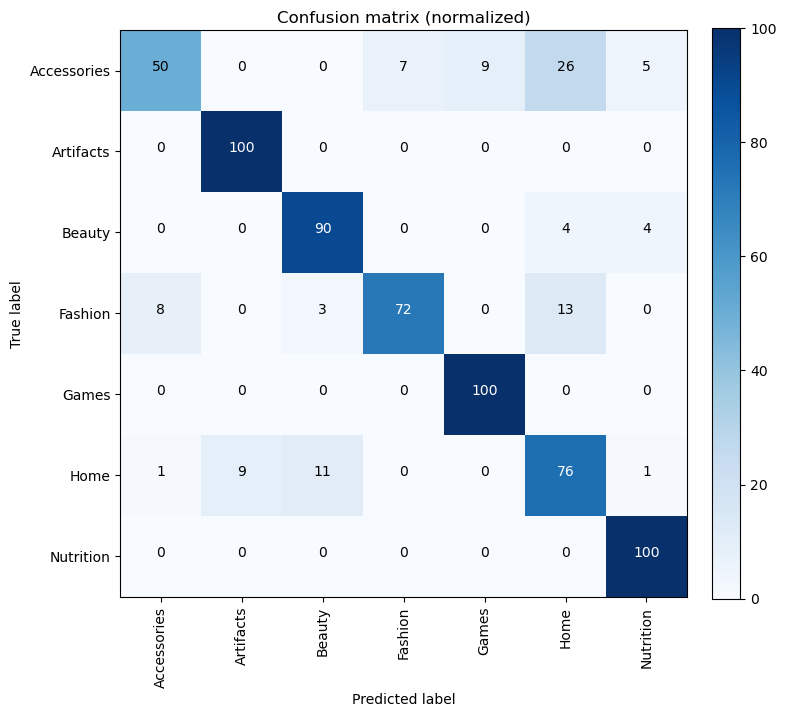

In [18]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm=cnf_matrix, classes=class_names, title='Confusion Matrix', normalize=True)


In [19]:
print(labels_true)
print(labels_pred)

[3, 5, 3, 0, 6, 0, 0, 5, 2, 2, 3, 5, 5, 4, 4, 5, 6, 5, 3, 5, 2, 3, 5, 3, 5]
[3, 5, 3, 4, 6, 5, 5, 5, 2, 2, 3, 5, 1, 4, 4, 1, 6, 5, 3, 5, 2, 3, 5, 3, 5]


In [2]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 435.7 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 326.8 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 326.8 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 326.8 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 326.8 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 326.8 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 326.8 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 326.8 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 326.8 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 326.8 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 